# Facility Data Deep Dive

## Violations, Inspections and Enforcements for Resource Conservation and Recovery Act (RCRA), Clean Water Act (CWA), Clean Air Act (CAA)

This notebook examines ECHO data on inspections, violations and enforcements by EPA, state and other agencies.  It uses the following data sets from the ECHO downloadable files:
<ul>
    <li>ECHO_EXPORTER - Facility information, especially derived FAC_DERIVED_CD113 for congressional districts.</li>
    <li>RCRA_EVALUATIONS</li>
    <li>RCRA_VIOLATIONS</li>
    <li>RCRA_ENFORCEMENTS</li>
    <li>ICIS_FEC_EPA_INSPECTIONS</li>
    <li>ICIS-AIR_VIOLATION_HISTORY</li>
    <li>CASE_FACILITIES & CASE_ENFORCEMENTS</li>
    <li>ICIS-AIR_FORMAL_ACTIONS</li>
    <li>ICIS-AIR_FCES_PCES</li>
    <li>NPDES_QNCR_HISTORY</li>
    <li>NPDES_INSPECTIONS</li>
    <li>NPDES_FORMAL_ENFORCEMENT_ACTIONS</li>
</ul>


#### A zip code must be chosen using the input widget that is provided.

## How to Run
* If you click on a gray **code** cell, a little “play button” arrow appears on the left. If you click the play button, it will run the code in that cell (“**running** a cell”). The button will animate. When the animation stops, the cell has finished running.
![Where to click to run the cell](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/pressplay.JPG?raw=true)
* You may get a warning that the notebook was not authored by Google. We know, we authored them! It’s okay. Click “Run Anyway” to continue. 
![Error Message](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/warning-message.JPG?raw=true)
* **It is important to run cells in order because they depend on each other.**
* Run all of the cells in a Notebook to make a complete report. Please feel free to look at and **learn about each result as you create it**!

---
---

# **Let's begin!**

### Hover over the "[ ]" on the top left corner of the cell below and you should see a "play" button appear. Click on it to run the cell then move to the next one.

### Run this next cell to create the widget for inputting your zip code. It will create an input field at the bottom. Enter your zip code and then move on to the next cell.

In [120]:
# Import libraries
import urllib.parse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import folium

def get_data( sql, index_field ):
    url='http://apps.tlt.stonybrook.edu/echoepa/?query='
    data_location=url+urllib.parse.quote(sql)
    ds = pd.read_csv(data_location,encoding='iso-8859-1')
    ds.set_index( index_field, inplace=True)
    return ds
 
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from IPython.display import display

zip_widget = widgets.IntText(
    value=1,
    description='Zip Code:',
    disabled=False
)
display( zip_widget )

IntText(value=1, description='Zip Code:')

### Run this cell after choosing a zip code. It will pull facility information from the data  in the  ECHO_EXPORTER table.

In [121]:
my_zip = zip_widget.value

sql = "select * from ECHO_EXPORTER where FAC_DERIVED_ZIP = " + str( my_zip ) #FAC_ZIP?

try:
    echo_data = get_data( sql, 'REGISTRY_ID' )
    num_facilities = echo_data.shape[0]
    print("\nThere are %s EPA facilities in Zip code %s tracked in the ECHO database." \
          %(num_facilities, my_zip))
except pd.errors.EmptyDataError:
    print("\nThere are no EPA facilities in this zip code.\n")


There are 104 EPA facilities in Zip code 53703 tracked in the ECHO database.


## Create an interactive map of all of the facilities in the area that report to EPA
### Once you run this cell, a map should appear. You can zoom in and out, or click on facilities to get their names and the EPA programs that monitor them.

The EPA program acronyms are:
<ul>
    <li>CAA = Clean Air Act</li>
    <li>CWA = Clean Water Act</li>
    <li>SDWIS = Safe Drinking Water Information System</li>
    <li>RCRA = Resource Conservation and Recovery Act</li>
    <li>TRI = Toxics Release Inventory</li>
    <li>GHG = Greenhouse Gas</li>
</ul>
The map won't display if there are too many markers, so only the first 200 are shown.

In [122]:
# [To do:  Use some ECHO_EXPORTER data to pick the top 200 facilities (by some measure) 
# to map.]

# Let's show a quick map of your area and the facilities in it
# To-do:  Add some more ECHO_EXPORTER information in the markers.

# Put some information with the marker to show the programs that track the facility.
def marker_text( row ):
    text = ""
    if ( type( row['FAC_NAME'] == str )) :
        try:
            text = row["FAC_NAME"] + ' - '
        except TypeError:
            print( "A facility was found without name. ")
        if ( row['AIR_FLAG'] == 'Y' ):
            text += 'CAA, ' 
        if ( row['NPDES_FLAG'] == 'Y' ):
            text += 'CWA, ' 
        if ( row['SDWIS_FLAG'] == 'Y' ):
            text += 'SDWIS, ' 
        if ( row['RCRA_FLAG'] == 'Y' ):
            text += 'RCRA, ' 
        if ( row['TRI_FLAG'] == 'Y' ):
            text += 'TRI, ' 
        if ( row['GHG_FLAG'] == 'Y' ):
            text += 'GHG, ' 
    return text
    
def mapper(df):
    # Initialize the map
    center = [df.mean()["FAC_LAT"], df.mean()["FAC_LONG"]]
    m = folium.Map(
        location = center,
    )

    # Add a clickable marker for each facility
    i = 0
    for index, row in df.iterrows():
        # Make sure the FAC_NAME is not NaN, which is interpreted as a number.
        if ( type( row['FAC_NAME'] == str )) :
            folium.Marker(
                location = [row["FAC_LAT"], row["FAC_LONG"]],
                popup = marker_text( row )).add_to(m)
            i += 1
        if ( i > 200 ):    # The map won't display with too many markers.
            break
            
    bounds = m.get_bounds()
    m.fit_bounds(bounds)
    
    # Show the map
    return m

map_of_facilities_in_zip = mapper(echo_data)
map_of_facilities_in_zip

## Graph data across all three programs, for all the facilities in the zip code. 
We will only show those facilities that have - for any EPA program - spent at least 1 quarter out of the past 12 in non-compliance, or that have had 1 inspection over the past 5 years, or that had 1 enforcement action taken against them.

In [ ]:
#### DELETE IN MAIN BRANCH
#### THIS WILL BE EXPANDED AND REWORKED TO ACTUALLY DRAW FROM THE PROGRAM-SPECIFIC SPREADSHEETS WE LOAD IN A CELL BELOW

chart_title = "All Facilities - Past 3 Years of Violations and 5 Years of Inspections and Enforcement Actions"
d = echo_data.loc[:,['FAC_NAME','FAC_QTRS_WITH_NC', 'FAC_INSPECTION_COUNT', 'FAC_INFORMAL_COUNT', 'FAC_FORMAL_ACTION_COUNT']]
d["FAC_ENF_COUNT"] = d["FAC_INFORMAL_COUNT"] + d["FAC_FORMAL_ACTION_COUNT"] # Calculate total enforcement actions
d=d.drop(['FAC_INFORMAL_COUNT', 'FAC_FORMAL_ACTION_COUNT'], axis=1)
d=d.reset_index(drop=True)
d=d.set_index("FAC_NAME")
d=d[(d["FAC_QTRS_WITH_NC"]>0) | (d["FAC_INSPECTION_COUNT"]>0) | (d["FAC_ENF_COUNT"]>0)] # Don't show facilities with 0 violations, or inspections, or enforcement actions

ax = d.plot(kind='bar', title = chart_title, figsize=(20, 10), fontsize=16)
ax.set_ylabel("Count", fontsize=16)
ax

## Graph program-specific data for all the facilities in the zip code.
### First, choose the program (Air, Water, or RCRA) and type of data (Violations, Inspections, Enforcement) you want to explore

What's available:
<ul>
    <li>RCRA Evaluations = Inspections under RCRA</li>
    <li>RCRA Violations</li>
    <li>RCRA Enforcements</li>
    <li>ICIS_FEC_EPA_INSPECTIONS = Inspections under CAA</li>
    <li>CAA Violations</li>
    <li>CAA Enforcements</li>
    <li>CAA Formal Enforcements</li>
    <li>CAA Full Partial Compliance</li>
    <li>CWA Quarterly Non-Compliance History</li>
    <li>CWA Inspections</li>
    <li>CWA Enforcements</li>
</ul>

In [123]:
zip_data_set_widget=widgets.Dropdown(
    options=['RCRA_EVALUATIONS','RCRA_VIOLATIONS', 'RCRA_ENFORCEMENTS', 'ICIS_FEC_EPA_INSPECTIONS'], # TO DO: Finish list. Create a lookup to make the dropdown options more user-friendly, with the actual spreadsheet names on the backend.
    description='Data sets:',
    disabled=False,
)
display(zip_data_set_widget)

Dropdown(description='Data sets:', options=('RCRA_EVALUATIONS', 'RCRA_VIOLATIONS', 'RCRA_ENFORCEMENTS', 'ICIS_…

In [124]:
# Get relevant program
program = zip_data_set_widget.value

# Get id tags from ECHO_EXPORTER for the relevant program
code = {"ICIS": "AIR_IDS", "NPDES": "NPDES_IDS", "RCRA": "RCRA_IDS"} # Todo: figure out case enforcements...
echo_code = [v for k,v in code.items() if k in zip_data_set_widget.value][0]


ids = echo_data.loc[echo_data[echo_code].str.len() >0]    # just give all RCRA_IDs and let sql deal with it?
ids = ids.loc[:,echo_code]

id_string = ""
for pos,row in enumerate(ids):
    id_string = id_string + "'"+row+"',"
id_string=id_string[:-1] # removes trailing comma
#print(id_string)

# Translate those id tags into what the specific spreadsheet wants
id_tags = {"ICIS": "AIR_IDS", "NPDES": "NPDES_IDS", "RCRA": "ID_NUMBER"}
index_field = [v for k,v in id_tags.items() if k in zip_data_set_widget.value][0]

sql = "select * from `"+program+"` where "+index_field+" in (" + \
            id_string + ")"

#print(sql, "'"+index_field+"'")
data = get_data( sql, index_field )

print( "Data from " + program + " loaded for this zip code!")

data

Data from RCRA_ENFORCEMENTS loaded for this zip code!


,ACTIVITY_LOCATION,ENFORCEMENT_IDENTIFIER,ENFORCEMENT_TYPE,ENFORCEMENT_DESC,ENFORCEMENT_AGENCY,ENFORCEMENT_ACTION_DATE,PMP_AMOUNT,FMP_AMOUNT,FSC_AMOUNT,SCR_AMOUNT
ID_NUMBER,,,,,,,,,,
WID006105936,WI,2,HQ120,WRITTEN INFORMAL,S,09/01/1993,NaN,NaN,NaN,NaN
WID006105936,WI,1,HQ120,WRITTEN INFORMAL,S,07/02/1985,NaN,NaN,NaN,NaN
WID006105936,WI,1,WI124,NOTICE OF NONCOMPLIANCE LETTER,S,06/04/1999,NaN,NaN,NaN,NaN
WID006424253,WI,1,WI124,NOTICE OF NONCOMPLIANCE LETTER,S,05/27/2003,NaN,NaN,NaN,NaN
WID099128373,WI,1,WI124,NOTICE OF NONCOMPLIANCE LETTER,S,10/31/2017,NaN,NaN,NaN,NaN
WID981778947,WI,1,WI124,NOTICE OF NONCOMPLIANCE LETTER,S,05/19/2003,NaN,NaN,NaN,NaN
WIR000157768,WI,1,WI124,NOTICE OF NONCOMPLIANCE LETTER,S,05/07/2019,NaN,NaN,NaN,NaN


### Let's chart this!

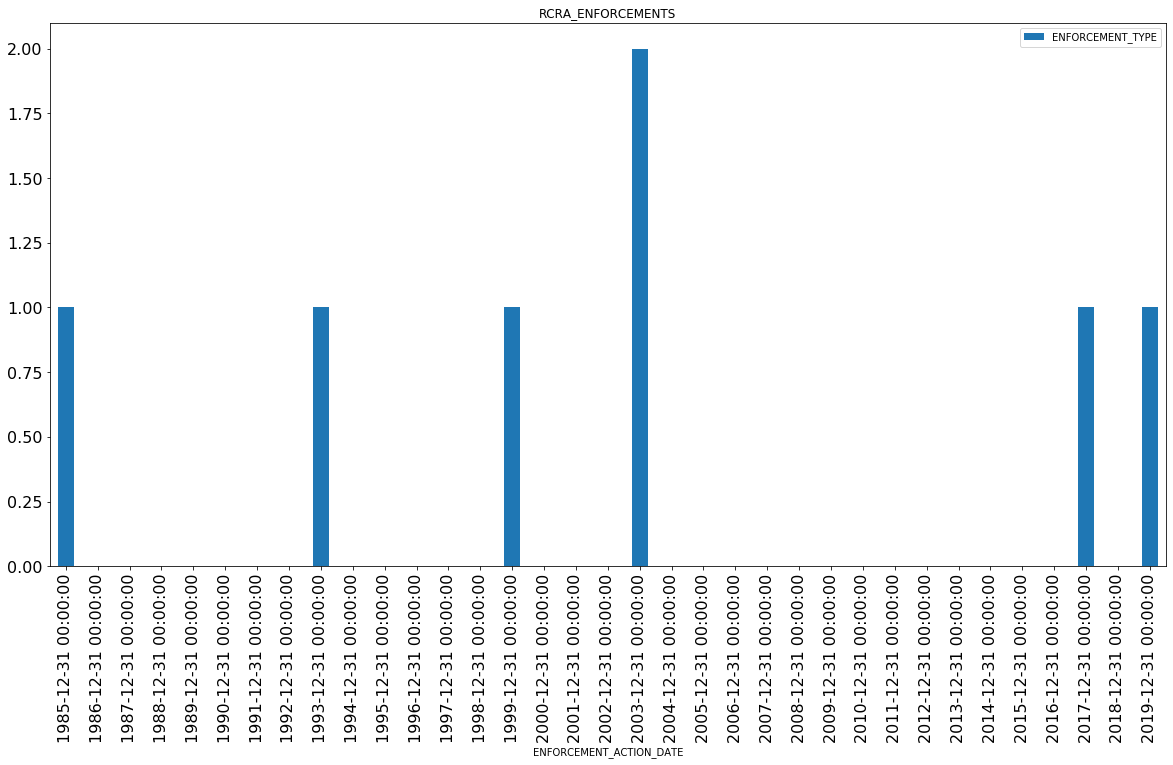

In [125]:
### Need to get column of interest!
columns = {"RCRA_ENFORCEMENTS": "ENFORCEMENT_TYPE"} # For raw counts/instances, any column will do?
columns_date = {"RCRA_ENFORCEMENTS": "ENFORCEMENT_ACTION_DATE"}
#date_format = #lookup date format

this_columns = columns[program]
this_columns_date = columns_date[program]

d = data.groupby(pd.to_datetime(data[this_columns_date], format="%m/%d/%Y"))[[this_columns]].count()
d = d.resample("Y").count()

ax = d.plot(kind='bar', title = program, figsize=(20, 10), fontsize=16)
ax

## Choose a specific facility
### Run the below cell, then choose a facility from the dropdown that appears to delve deeper into data on inspections, violations and enforcements at a single facility.

In [126]:
cd_array = echo_data["FAC_NAME"].dropna().unique()
cd_array.sort()

fac_widget=widgets.Dropdown(
    options=cd_array,
    description='Facility Name:',
    disabled=False,
)
display(fac_widget)

Dropdown(description='Facility Name:', options=('701 EAST WASHINGTON LLC', '722 WILLIAMSON', 'ALL LAMP RECYCLI…

### The next cells filter the program-specific IDs to get just records for the selected facility.

In [127]:
# Keep track of which data sets are retrieved.
have_rcra_insp = False
have_rcra_viol = False
have_rcra_enf = False
have_air_insp = False
have_air_viol = False
have_air_enf = False
have_air_formal = False
have_air_comp = False
have_water_history = False
have_water_insp = False
have_water_enf = False
    
my_fac = echo_data[echo_data["FAC_NAME"] == fac_widget.value]
if ( my_fac['RCRA_FLAG'].iloc[0] == 'Y' ):
    rcra_id_string = my_fac['RCRA_IDS'].tolist()
    
    try:
        sql = "select * from `RCRA_EVALUATIONS` where ID_NUMBER in ( '" + \
            "', '".join( rcra_id_string[0].split() ) + "')"
        rcra_insp_data = get_data( sql, "ID_NUMBER" )
        print( "Data from RCRA_EVALUATIONS stored in rcra_insp_data.")
        have_rcra_insp = True
    except pd.errors.EmptyDataError:
        print( "No data for this facility in RCRA_EVALUATIONS.")
    
    try:
        sql = "select * from `RCRA_VIOLATIONS` where ID_NUMBER in ( '" + \
            "', '".join( rcra_id_string[0].split() ) + "')"
        rcra_viol_data = get_data( sql, "ID_NUMBER" )
        print( "Data from RCRA_VIOLATIONS stored in rcra_viol_data.")
        have_rcra_viol = True
    except pd.errors.EmptyDataError:
        print( "No data for this facility in RCRA_VIOLATIONS.")
    
    try:
        sql = "select * from `RCRA_ENFORCEMENTS` where ID_NUMBER in ( '" + \
            "', '".join( rcra_id_string[0].split() ) + "')"
        rcra_enf_data = get_data( sql, "ID_NUMBER" )
        print( "Data from RCRA_ENFORCEMENTS stored in rcra_enf_data.")
        have_rcra_enf = True
        # print( rcra_enf_data )
    except pd.errors.EmptyDataError:
        print( "No data for this facility in RCRA_ENFORCEMENTS.")
 
if ( my_fac['AIR_FLAG'].iloc[0] == 'Y' ):
    air_id_string = my_fac['AIR_IDS'].tolist()
    
    try:
        sql = "select * from `ICIS_FEC_EPA_INSPECTIONS` where REGISTRY_ID = '" + \
            str(int( my_fac.index[0] )) + "'"
        air_insp_data = get_data( sql, "ID_NUMBER" )
        print( "Data from ICIS_FEC_EPA_INSPECTIONS stored in air_insp_data.")
        have_air_insp = True
        # print( air_insp_data )
    except pd.errors.EmptyDataError:
        print( "No data for this facility in ICIS_FEC_EPA_INSPECTIONS.")
    
    try:
        sql = "select * from `ICIS-AIR_VIOLATION_HISTORY` where PGM_SYS_ID in ( '" + \
            "', '".join( air_id_string[0].split() ) + "')"
        air_viol_data = get_data( sql, "pgm_sys_id" )
        print( "Data from ICIS-AIR_VIOLATION_HISTORY stored in air_viol_data.")
        have_air_viol = True
        # print( air_viol_data )
    except pd.errors.EmptyDataError:
        print( "No data for this facility in ICIS-AIR_VIOLATION_HISTORY.")
    
    try:
        sql = "select * from `CASE_FACILITIES` CF, `CASE_ENFORCEMENTS` CE " + \
            " where CE.HQ_DIVISION = 'AIR' and CE.CASE_NUMBER = CF.CASE_NUMBER and " + \
            " CF.REGISTRY_ID = '" + str(int( my_fac.index[0] )) + "'"
        air_enf_data = get_data( sql, "REGISTRY_ID" )
        print( "Data from CASE_ENFORCEMENTS stored in air_enf_data.")
        have_air_enf = True
        # print( air_enf_data )
    except pd.errors.EmptyDataError:
        print( "No data for this facility in CASE_ENFORCEMENTS.")    

    try:
        sql = "select * from `ICIS-AIR_FORMAL_ACTIONS` where PGM_SYS_ID in ( '" + \
            "', '".join( air_id_string[0].split() ) + "')"
        air_formal_data = get_data( sql, "pgm_sys_id" )
        print( "Data from ICIS-AIR_FORMAL_ACTIONS stored in air_formal_data.")
        have_air_formal = True
        # print( air_formal_data )
    except pd.errors.EmptyDataError:
        print( "No data for this facility in ICIS-AIR_FORMAL_ACTIONS.")
    
    try:
        sql = "select * from `ICIS-AIR_FCES_PCES` where PGM_SYS_ID in ( '" + \
            "', '".join( air_id_string[0].split() ) + "')"
        air_comp_data = get_data( sql, "PGM_SYS_ID" )
        print( "Data from ICIS-AIR_FCES_PCES stored in air_comp_data.")
        have_air_comp = True
        # print( air_comp_data )
    except pd.errors.EmptyDataError:
        print( "No data for this facility in ICIS-AIR_FCES_PCES.")
    
if ( my_fac['NPDES_FLAG'].iloc[0] == 'Y' ):
    water_id_string = my_fac['NPDES_IDS'].tolist()
    
    try:
        sql = "select * from `NPDES_QNCR_HISTORY` where NPDES_ID in ( '" + \
            "', '".join( water_id_string[0].split() ) + "')"
        water_history_data = get_data( sql, "NPDES_ID" )
        print( "Data from NPDES_QNCR_HISTORY stored in water_history_data.")
        have_water_history = True
        # print( water_insp_data )
    except pd.errors.EmptyDataError:
        print( "No data for this facility in NPDES_QNCR_HISTORY.")
    
    try:
        sql = "select * from `NPDES_INSPECTIONS` where NPDES_ID in ( '" + \
            "', '".join( water_id_string[0].split() ) + "')"
        water_insp_data = get_data( sql, "NPDES_ID" )
        print( "Data from NPDES_INSPECTIONS stored in water_insp_data.")
        have_water_insp = True
        # print( water_insp_data )
    except pd.errors.EmptyDataError:
        print( "No data for this facility in NPDES_INSPECTIONS.")

    try:
        sql = "select * from `NPDES_FORMAL_ENFORCEMENT_ACTIONS` where NPDES_ID in ( '" + \
            "', '".join( water_id_string[0].split() ) + "')"
        water_enf_data = get_data( sql, "NPDES_ID" )
        print( "Data from NPDES_FORMAL_ENFORCEMENT_ACTIONS stored in water_enf_data.")
        have_water_enf = True
        # print( water_enf_data )
    except pd.errors.EmptyDataError:
        print( "No data for this facility in NPDES_FORMAL_ENFORCEMENT_ACTIONS.")
    

Data from RCRA_EVALUATIONS stored in rcra_insp_data.
No data for this facility in RCRA_VIOLATIONS.
No data for this facility in RCRA_ENFORCEMENTS.
No data for this facility in ICIS_FEC_EPA_INSPECTIONS.
Data from ICIS-AIR_VIOLATION_HISTORY stored in air_viol_data.
No data for this facility in CASE_ENFORCEMENTS.
Data from ICIS-AIR_FORMAL_ACTIONS stored in air_formal_data.
Data from ICIS-AIR_FCES_PCES stored in air_comp_data.
Data from NPDES_QNCR_HISTORY stored in water_history_data.
Data from NPDES_INSPECTIONS stored in water_insp_data.
No data for this facility in NPDES_FORMAL_ENFORCEMENT_ACTIONS.


## Show the information from one of the data sets for this facility
Running this cell will create a dropdown list of the program data sets available for this faciliity. Pick one and then run the second cell to view its contents. To see additional data, return to the dropdown to choose a new value and repeat.

In [128]:
data_set_dict = { "ECHO_EXPORTER" : my_fac }
if ( have_rcra_insp ):
    data_set_dict["RCRA Inspections"] = rcra_insp_data
if ( have_rcra_viol ):
    data_set_dict["RCRA Violations"] = rcra_viol_data
if ( have_rcra_enf ):
    data_set_dict["RCRA Enforcements"] = rcra_enf_data
if ( have_air_insp ):
    data_set_dict["Air Inspections"] = air_insp_data
if ( have_air_viol ):
    data_set_dict["Air Violations"] = air_viol_data
if ( have_air_enf ):
    data_set_dict["Air Enforcements"] = air_enf_data
if ( have_air_formal ):
    data_set_dict["Air Formal Actions"] = air_formal_data
if ( have_air_comp ):
    data_set_dict["Air Compliance"] = air_comp_data
if ( have_water_history ):
    data_set_dict["Water QNCR History"] = water_history_data
if ( have_water_insp ):
    data_set_dict["Water Inspections"] = water_insp_data
if ( have_water_enf ):
    data_set_dict["Water Enforcements"] = water_enf_data

data_set_widget=widgets.Dropdown(
    options=list(data_set_dict.keys()),
    description='Data sets:',
    disabled=False,
)
display(data_set_widget)

Dropdown(description='Data sets:', options=('ECHO_EXPORTER', 'RCRA Inspections', 'Air Violations', 'Air Formal…

In [129]:
print( "Showing %s data for the chosen facility" %( data_set_widget.value ))
data_set_dict[data_set_widget.value] 

Showing Air Violations data for the chosen facility


,ACTIVITY_ID,AGENCY_TYPE_DESC,STATE_CODE,AIR_LCON_CODE,COMP_DETERMINATION_UID,ENF_RESPONSE_POLICY_CODE,PROGRAM_CODES,PROGRAM_DESCS,POLLUTANT_CODES,POLLUTANT_DESCS,EARLIEST_FRV_DETERM_DATE,HPV_DAYZERO_DATE,HPV_RESOLVED_DATE
pgm_sys_id,,,,,,,,,,,,,
WI0000005502500003,3400362064,U.S. EPA,NaN,NaN,05000F0000550250000300051,HPV,CAASIP,State Implementation Plan for National Primary...,10461,Sulfur dioxide,NaN,05-18-1994,07-13-1994


### Compile and chart information by program
Look at violations, inspections, and enforcements at this facility for each program - the CAA, CWA, and RCRA

In [132]:
#### SAVE THIS FOR FUTURE ITERATIONS.
#### CURRENT GOAL: CHANGE TO CHART BY INDIVIDUAL SPREADSHEET, 
#### NOT BY ALL SPREADSHEETS IN A MEDIA (OR CROSS-MEDIA/PROGRAM)
#### SO, THIS CELL SHOULD JUST BECOME THE CELL THAT CHARTS THE SELECTION MADE ABOVE ^^^^

options = []

dic={"Air":[have_air_viol,have_air_insp,have_air_enf, have_air_comp, have_air_formal], 
      "Water": [have_water_history, have_water_insp, have_water_enf],
      "RCRA": [have_rcra_viol, have_rcra_insp, have_rcra_enf]
     }

for opt in dic:
    if True in dic[opt]:
        options.append(opt)

program_widget=widgets.Dropdown(
    options=options,
    description='Programs:',
    disabled=False,
)
display(program_widget)

Dropdown(description='Programs:', options=('Air', 'Water', 'RCRA'), value='Air')

In [ ]:
#### CAN CUT FOR NOW....

chart_title = program_widget.value

d = {k:v for k,v in data_set_dict.items() if program_widget.value in k} # Getting the program-relevant data
k = list(d.keys()) # Figuring out which spreadsheets we have available (inspections? enforcement? violations?)
print(k)

if (program_widget.value == "Water"):
    # Lots of logic needed here to sort through the different spreadsheets we may have. Is there a simpler approach???
    if ("Water QNCR History" in k): 
        year=data_set_dict["Water QNCR History"]["YEARQTR"].astype("str").str[0:4:1]
        d["Water QNCR History"]["YEARQTR"]=year
        d["Water QNCR History"] = d["Water QNCR History"].groupby(pd.to_datetime(d["Water QNCR History"]['YEARQTR'], format="%Y").dt.to_period("Y")).sum()
    if ("Water Inspections" in k):
        d["Water Inspections"] = d["Water Inspections"].groupby(pd.to_datetime(d["Water Inspections"]['ACTUAL_END_DATE'], format="%m/%d/%Y").dt.to_period("Y"))[["REGISTRY_ID"]].count()
    # More spreadsheet prepping needed here
    program = pd.concat([d[k[0]]], axis=1, sort=False) # Do for all spreadsheets in k...
    #print(program)
elif (program_widget.value == "Air"):
    d["Air Violations"] = d["Air Violations"].groupby(pd.to_datetime(d["Air Violations"]['HPV_DAYZERO_DATE'], format="%m-%d-%Y"))[['POLLUTANT_CODES']].count()
    d['Air Formal Actions']= d["Air Formal Actions"].groupby(pd.to_datetime(d["Air Formal Actions"]['SETTLEMENT_ENTERED_DATE'], format="%m/%d/%Y"))[['ENF_TYPE_DESC']].count()
    program = pd.concat([d[k[0]], d[k[1]]], axis=1, sort=False)
    # More needed here ... 
    print(program)
elif (program_widget.value == "RCRA"):
    d["RCRA Inspections"] = d["RCRA Inspections"].groupby(pd.to_datetime(d["RCRA Inspections"]['EVALUATION_START_DATE'], format="%m/%d/%Y"))[['ACTIVITY_LOCATION']].count()
    program = d[k[0]]
    # Fill this out
    print(program)

ax = program.plot(kind='bar', title = chart_title, figsize=(20, 10), fontsize=16)
ax

## This section saves the facility data to your computer.
The first of the next two cells ask you to select one of the data sets to export from the dropdown list.  The next cell actually exports that data to your computer.  You can return to the dropdown to export additional data files.

Note: When you click on [] in the second cell, it may continue to show \*. That's to be expected! Check your Downloads folder and confirm that the spreadsheet was succesfully exported. Hit the square button (Interrupt Kernel) at the top of the page. You can now choose to export other data sets from the dropdown...

In [137]:
data_download_widget=widgets.Dropdown(
    options=list(data_set_dict.keys()),
    description='Data Sets:',
    disabled=False,
)
display(data_download_widget)

Dropdown(description='Data Sets:', options=('ECHO_EXPORTER', 'RCRA Inspections', 'Air Violations', 'Air Formal…

In [138]:
filename = data_download_widget.value
fullpath = filename+'.csv'
data_set_dict[data_download_widget.value].to_csv( fullpath ) 

print( "Wrote "+filename+" to the 'Files' menu as %s" %(fullpath))

Wrote Water QNCR History to this data to Water QNCR History.csv


### Accessing your files
Click on the 'Files' tab in the menu on the left-hand side of the notebook (it looks like a folder). You may have to hit 'Refresh' if you don't see your file. Then, you can click on the ... next to your file and choose "Download". The CSV spreadsheet will download to wherever your browser usually saves files (e.g. Downloads folder)